## Loading libraries

In [1]:
import keras
from keras.models import load_model
from keras.utils.layer_utils import count_params
import matplotlib.pyplot as plt
import numpy as np
import scipy

## Dataset and functions preparation

In [2]:
#Inverse Cholesky transformation using 4 outputs predicted by the neural network
def prediction_to_density(flat):
    tau = np.zeros([flat.shape[0], 2, 2], dtype=np.complex_)
    tau[:, 0, 0] = flat[:, 0]
    tau[:, 0, 1] = 0
    tau[:, 1, 0] = flat[:, 1] + 1j*flat[:, 2]
    tau[:, 1, 1] = flat[:, 3]
    rho = np.zeros([tau.shape[0], 2, 2], dtype=np.complex_)
    for i in range(rho.shape[0]):
        rho[i] = np.dot(tau[i], np.conjugate(np.transpose(tau[i])))
        rho[i] = rho[i] / np.trace(rho[i])
    return rho

#Computing fidelity
def fidelity_array(input_1, input_2):
    fid_int = []
    for i in range(input_1.shape[0]):
        dm_sqrt = scipy.linalg.sqrtm(input_1[i])
        dm_pred = input_2[i]
        in_sqrt = np.linalg.multi_dot([dm_sqrt, dm_pred, dm_sqrt])
        trace = np.trace(scipy.linalg.sqrtm(in_sqrt))
        fidelity = np.real(trace**2)
        fid_int.append(fidelity)
    return np.array(fid_int)

In [3]:
#Loading the dataset of density matrices and control voltages
train_voltage = np.load("Data_files/training_voltages.npy")
val_voltage = np.load("Data_files/validation_voltages.npy")
test_voltage = np.load("Data_files/test_voltages.npy")

train_rho = np.load("Data_files/training_rhos.npy")
val_rho = np.load("Data_files/validation_rhos.npy")
test_rho = np.load("Data_files/test_rhos.npy")

## Evaluating results

In [5]:
average_fidelities = np.zeros([8])
number_of_parameters = np.zeros([8])

for i in range(average_fidelities.shape[0]-1):
    #Loading the current sub-optimal direct neural network
    current_model = load_model("Auxiliary_models/Direct_model_1_"+str(int(128/(2**(i))))+"_parameters.h5")
    
    #Prediction of the current sub-optimal direct model on the test set
    test_pred_rho = prediction_to_density(current_model.predict(test_voltage))
    
    #Evaluation of results
    current_fidelities = fidelity_array(test_rho, test_pred_rho)
    
    #Saving results and number of parameters
    average_fidelities[i] = np.mean(current_fidelities)
    number_of_parameters[i] = current_model.count_params()
    
#Loading and evaluating the optimal direct neural network
direct_model = load_model("Direct_model.h5")
test_pred_rho = prediction_to_density(direct_model.predict(test_voltage))
direct_fidelities = fidelity_array(test_rho, test_pred_rho)
average_fidelities[-1] = np.mean(direct_fidelities)
number_of_parameters[-1] = direct_model.count_params()

## Visualizing results

Text(0.5, 0, 'Trainable parameters')

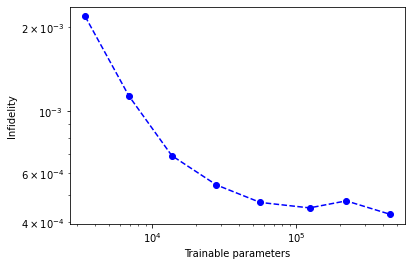

In [6]:
plt.figure(figsize=(6,4))
plt.plot(number_of_parameters, 1-average_fidelities, 
         color="blue", linestyle="--")
plt.scatter(number_of_parameters, 1-average_fidelities, 
            color="blue")

plt.xscale("log")
plt.yscale("log")
plt.ylabel("Infidelity")
plt.xlabel("Trainable parameters")